In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from efficient_apriori import apriori

from importlib import reload
acg = reload(acg)
bcl = reload(bcl)
bcg = reload(bcg)


In [2]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


In [3]:
def get_negative_entries(gur):
    df_emp_access = pd.read_csv('data/train.csv')
    
    attnames_list = list(df_emp_access.columns)[2:]

    #---Group by the column header: attvalues, residx, resolution---
    dfgb_temp = df_emp_access.groupby(attnames_list + ['RESOURCE','ACTION'])
    df_temp = dfgb_temp.size().to_frame(name = 'count').reset_index()
    df_temp = df_temp.drop('count', axis=1)

    #---Add user indexes---
    dfgb_temp = df_temp.groupby(attnames_list)

    dfs_list = []
    usridx = 0
    for _,df in dfgb_temp:
        k = df.shape[0]
        df.insert(loc=0, column='USR_ID', value=[usridx for _ in range(k)])
        dfs_list.append(df)
        usridx += 1
    df_temp = pd.concat(dfs_list)

    df_entries = df_temp[['USR_ID', 'RESOURCE', 'ACTION']]

    df_neg_entries = df_entries[df_entries['ACTION']==0]

    dfgb_neg = df_neg_entries.groupby(['USR_ID','RESOURCE'])
    df_temp_neg = dfgb_neg.size().to_frame(name = 'COUNT').reset_index()
    usrid_to_resid_neg = df_temp_neg[['USR_ID','RESOURCE']].values.tolist()
    
    #Map ids to indexes in the graph
    usrid_to_vidx = dict()
    resid_to_vidx = dict()
    for v in gur.vs:
        if v['type'] == False:
            usrid = int(v['name'][6:])
            usrid_to_vidx[usrid] = v.index
        else:
            resid = int(v['name'][6:])
            resid_to_vidx[resid] = v.index
    
    usrvidx_to_resvidx_neg = list()
    for tup in usrid_to_resid_neg:
        usrid = tup[0]
        resid = tup[1]
        if usrid in usrid_to_vidx and resid in resid_to_vidx:
            usrvidx_to_resvidx_neg.append((usrid_to_vidx[usrid], resid_to_vidx[resid]))
            
    return usrvidx_to_resvidx_neg



def get_positive_entries(gur, numentries, sd):
    random.seed(sd)
    usrvidx_to_resvidx_pos = []

    es_sampled = random.sample(sorted(gur.es),numentries)
    for e in es_sampled:
        usrvidx = e.source
        resvidx = e.target
        usrvidx_to_resvidx_pos.append((usrvidx, resvidx))
        
    gur2 = copy.deepcopy(gur)
    gur2.delete_edges(es_sampled)
    
    return usrvidx_to_resvidx_pos, gur2
    
  

In [12]:
def res_requesters_distrib(usrvidx_to_resvidx):
    resvidxset = set()
    for tup in usrvidx_to_resvidx:
        resvidxset.add(tup[1])
    num_requesters = []
    for resvidx in list(resvidxset):
        num_requesters.append(len(gur.neighbors(resvidx)))

    num_requesters_to_freq = dict(Counter(num_requesters))
    num_requesters_to_freq = dict(sorted(num_requesters_to_freq.items(), key=lambda item: item[1]))

    plt.plot(num_requesters_to_freq.keys(), num_requesters_to_freq.values(), '.')
    plt.xlabel('num requesters')
    plt.ylabel('freq')
    plt.show()

In [13]:
usrvidx_to_resvidx_neg = get_negative_entries(gur)

In [14]:
len(usrvidx_to_resvidx_neg)

1152

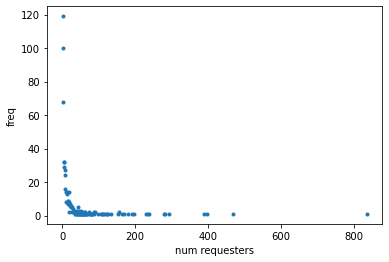

In [15]:
res_requesters_distrib(usrvidx_to_resvidx_neg)

In [16]:
usrvidx_to_resvidx_pos, gur2 = get_positive_entries(gur, len(usrvidx_to_resvidx_neg), 13)

In [17]:
len(usrvidx_to_resvidx_pos)

1152

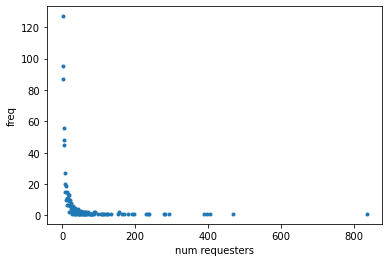

In [20]:
res_requesters_distrib(usrvidx_to_resvidx_pos)

### Similarity functions

In [31]:
#Matrix required to compute distance based similarity
D = gur2.distances()
D2 = np.array(D)
D2[~np.isfinite(D2)] = 1

In [21]:
def commonneigh_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for usrvidx2 in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[usrvidx2]))    
    rneighs = gur.neighbors(rv)
    cn = len(set(uneighs2)&set(rneighs))
    return cn

In [34]:
def jaccard_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for usrvidx2 in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[usrvidx2]))    
    rneighs = gur.neighbors(rv)
    js = len(set(uneighs2)&set(rneighs))/len(set(uneighs2)|set(rneighs))
    return js

In [29]:
def cosine_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for usrvidx2 in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[usrvidx2]))    
    rneighs = gur.neighbors(rv)
    cs = len(set(uneighs2)&set(rneighs))/math.sqrt(len(uneighs)*len(rneighs))
    return cs

In [44]:
def aa_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for usrvidx2 in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[usrvidx2]))    
    rneighs = gur.neighbors(rv)
    aasim = 0
    for usrvidx3 in list(set(uneighs2)&set(rneighs)):
        den = len(gur.neighbors(gur.vs[usrvidx3]))
        if den == 1:
            aasim += 1/100
        else:
            aasim += 1/math.log(den,10)
        
    return aasim

In [48]:
def pa_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    rneighs = gur.neighbors(rv)
    pa = len(uneighs) * len(rneighs)
    return pa

In [32]:
def geodist(gur, usrvidx, resvidx):
    #gur is ignored
    return D2[usrvidx][resvidx]

In [26]:
def plot_simdistribs(simfunc, bins, isLog=False):

    sim_neg = []
    for tup in usrvidx_to_resvidx_neg:
        usrvidx = tup[0]
        resvidx = tup[1]
        sim = simfunc(gur, usrvidx, resvidx)
        sim_neg.append(sim)

    sim_pos = []
    for tup in usrvidx_to_resvidx_pos:
        usrvidx = tup[0]
        resvidx = tup[1]
        sim = simfunc(gur, usrvidx, resvidx)
        sim_pos.append(sim)

    plt.hist(sim_neg,bins=bins,color='tab:red')
    plt.hist(sim_pos,bins=bins,alpha=0.8,color='tab:green')
    if isLog:
        plt.xscale('log')
    plt.xlabel('sim')
    plt.legend(['neg', 'pos'])
    plt.show()
    

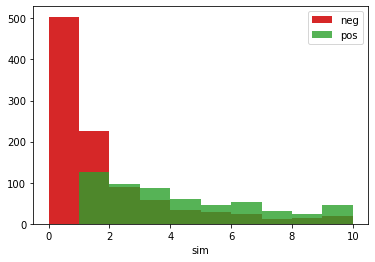

In [27]:
#Common neighbors similarity
bins = np.linspace(0, 10, 11)
plot_simdistribs(commonneigh_sim, bins, isLog=False)

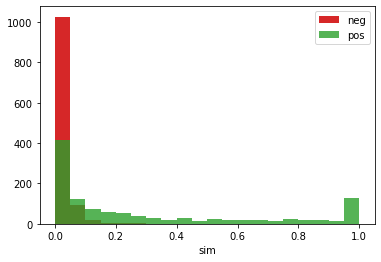

In [37]:
#Jaccard similarity
bins = np.linspace(0, 1, 21)
plot_simdistribs(jaccard_sim, bins, isLog=False)

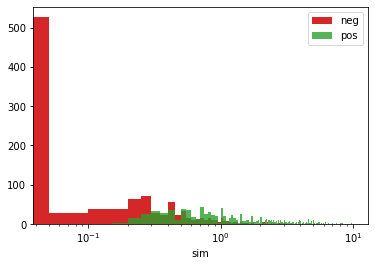

In [30]:
#Cosine similarity
bins = np.linspace(0, 10, 201)
plot_simdistribs(cosine_sim, bins, isLog=True)

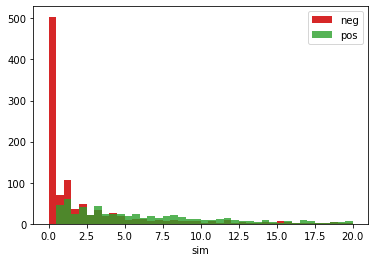

In [47]:
#Adamic-adar similarity
bins = np.linspace(0, 20, 41)
plot_simdistribs(aa_sim, bins, isLog=False)

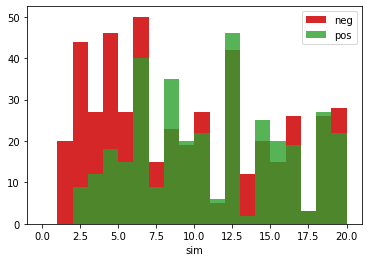

In [51]:
#Preferential attachment similarity
bins = np.linspace(0, 20, 21)
plot_simdistribs(pa_sim, bins, isLog=False)  

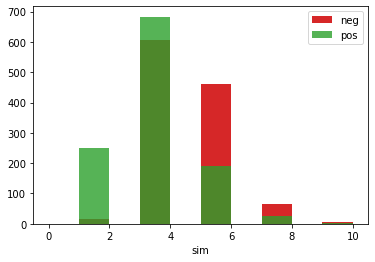

In [33]:
#Similarity based in geodesic distance
bins = np.linspace(0, 10, 11)
plot_simdistribs(geodist, bins, isLog=False)  

In [85]:
userlog_objs = []
for v in gur.vs:
    if v['type'] == False:
        userlog_obj = []
        for attname in v.attribute_names():
            if not attname in ['type','name']:
                userlog_obj.append(v[attname])
        userlog_objs.append(userlog_obj)

userlog_objs = ut.to_tuple_format(userlog_objs)

In [86]:
def get_neighattvals(gur, resvidx, usrvidx_excluded):
    neighattvals = set()
    for usrvidx in gur.neighbors(gur.vs[resvidx]):
        if usrvidx != usrvidx_excluded:
            neighattvals |= set(userlog_objs[usrvidx])   
    return neighattvals

numatts_neg = []
for tup in usrvidx_to_resvidx_neg:
    usrvidx = tup[0]
    resvidx = tup[1]
    neighattvals = get_neighattvals(gur, resvidx, usrvidx)
    usrattvals = set(userlog_objs[usrvidx])
    numatts_neg.append(len(usrattvals&neighattvals))
    
numatts_pos = []
for tup in usrvidx_to_resvidx_pos:
    usrvidx = tup[0]
    resvidx = tup[1]
    neighattvals = get_neighattvals(gur, resvidx, usrvidx)
    usrattvals = set(userlog_objs[usrvidx])
    numatts_pos.append(len(usrattvals&neighattvals))    

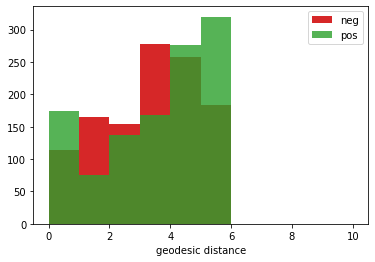

In [87]:
bins = np.linspace(0, 10, 11)
plt.hist(numatts_neg,bins=bins,color='tab:red')
plt.hist(numatts_pos,bins=bins,alpha=0.8,color='tab:green')
plt.xlabel('geodesic distance')
plt.legend(['neg', 'pos'])
plt.show()

In [79]:
Counter(numatts_pos)

Counter({5: 1152})